In [1]:
!pip install gym[atari]
!pip install gym[accept-rom-license]
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=7de8f7629ce30d229c82e1c957f30570827fcb49eb7527bcc83fcfca3a9cc09b
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated

episode: 0/300, score: 0.0, e: 1.0
episode: 1/300, score: 3.0, e: 1.0
episode: 2/300, score: 3.0, e: 1.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


episode: 3/300, score: 1.0, e: 0.46
episode: 4/300, score: 0.0, e: 0.16
episode: 5/300, score: 1.0, e: 0.027
episode: 6/300, score: 1.0, e: 0.01
episode: 7/300, score: 2.0, e: 0.01
episode: 8/300, score: 1.0, e: 0.01
episode: 9/300, score: 4.0, e: 0.01
episode: 10/300, score: 3.0, e: 0.01
episode: 11/300, score: 1.0, e: 0.01
episode: 12/300, score: 4.0, e: 0.01
episode: 13/300, score: 1.0, e: 0.01
episode: 14/300, score: 0.0, e: 0.01
episode: 15/300, score: 0.0, e: 0.01
episode: 16/300, score: 0.0, e: 0.01
episode: 17/300, score: 0.0, e: 0.01
episode: 18/300, score: 0.0, e: 0.01
episode: 19/300, score: 0.0, e: 0.01
episode: 20/300, score: 0.0, e: 0.01
episode: 21/300, score: 0.0, e: 0.01
episode: 22/300, score: 0.0, e: 0.01
episode: 23/300, score: 1.0, e: 0.01
episode: 24/300, score: 0.0, e: 0.01
episode: 25/300, score: 0.0, e: 0.01
episode: 26/300, score: 1.0, e: 0.01
episode: 27/300, score: 1.0, e: 0.01
episode: 28/300, score: 0.0, e: 0.01
episode: 29/300, score: 0.0, e: 0.01
episode

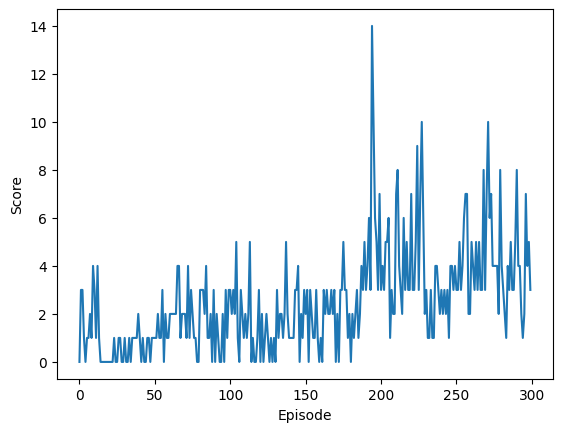

In [2]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation, TransformObservation

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义神经网络
class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# 定义DQN代理
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.00025
        self.batch_size = 32
        self.train_start = 1000

        self.model = DQN(action_size).to(device)
        self.target_model = DQN(action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        state = state.squeeze(-1)  # 去掉最后一个维度
        act_values = self.model(state)
        return torch.argmax(act_values, dim=1).item()

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        minibatch = random.sample(self.memory, self.batch_size)

        states = torch.FloatTensor(np.stack([e[0] for e in minibatch])).to(device)
        states = states.squeeze(-1)  # 去掉最后一个维度
        actions = torch.LongTensor(np.array([e[1] for e in minibatch])).to(device)
        rewards = torch.FloatTensor(np.array([e[2] for e in minibatch])).to(device)
        next_states = torch.FloatTensor(np.stack([e[3] for e in minibatch])).to(device)
        next_states = next_states.squeeze(-1)  # 去掉最后一个维度
        dones = torch.FloatTensor(np.array([e[4] for e in minibatch]).astype(np.uint8)).to(device)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = F.mse_loss(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 创建并包装环境
env = gym.make('Breakout-v4')
env = GrayScaleObservation(env, keep_dim=True)
env = ResizeObservation(env, 84)
env = TransformObservation(env, lambda obs: obs / 255.0)
env = FrameStack(env, 4)

state_size = (4, 84, 84)
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)

episodes = 300
scores = []

for e in range(episodes):
    state = env.reset()
    state = np.array(state)
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array(next_state)
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        total_reward += reward

        if done:
            agent.update_target_model()
            scores.append(total_reward)
            print(f"episode: {e}/{episodes}, score: {total_reward}, e: {agent.epsilon:.2}")
            break

        agent.replay()

env.close()

# 绘制得分曲线
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()
